In [1]:
# RECONSTRUCTION TEST 

import numpy as np
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

from keras.models import load_model
from keras import losses
import keras.backend as K

import librosa
import librosa.display

# iPython specific stuff
import IPython.display
from ipywidgets import interact, interactive, fixed

Using TensorFlow backend.


In [ ]:
def compute_spectra(x, fft_size, hop_size):

    # get options for computing spectra
    no_fft = fft_size                      # fft length
    hop = hop_size                         # hop size

    # STFT for the vector
    # (S is a complex matrix with the magnitude and phase of the fourier transform)
    S = librosa.core.stft(y=x,n_fft=no_fft,hop_length=hop_size)

    phase = np.angle(S)
    # Take the magnitude with abs (call it Z) and return log(1 + Z) as the spectrogram
    mag = np.log1p(np.abs(S))

    return mag, phase

### *If testing with sinusoids*

In [ ]:
# get the reconstruction from a test sinusoid
import matplotlib.pyplot as plt
import librosa
import librosa.display 

# get a sinusoid from the sine_dataset
dataset = np.load('dataset_test.npz','r')
data = dataset['spectrograms']
norms = dataset['norms']
x_test = data[1500]
norm = norms[1500]

print('Test spectogram shape:', S.shape)
print('Normalisation factor:', norm)
# create a test spectrogram
x_test = np.reshape(S,newshape=(1, 128, 776, 1))
print('Test spectogram of shape', x_test.shape)

# spectrogram prediction
y_test = model.predict(x_test)
print('Decoded image dimensions:', y_test.shape)

# reshape decoded_img in a 2D spectrogram
y_test = np.reshape(y_test,newshape=(128,776))
print('Decoded image after reshaping:',y_test.shape)

# display original
fig = plt.figure(figsize=[12, 4])
librosa.display.specshow(x_test*norm, sr=44100, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.tight_layout()
plt.show()

# display reconstruction
fig = plt.figure(figsize=[12, 4])
librosa.display.specshow(y_test*norm, sr=44100, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.tight_layout()
plt.show()

### *If testing with MNIST*

#### Model with sparsity as regularisation for each layer
(*load this when sparsity is applied to the loss function*)

In [2]:
from keras import regularizers

# the KL divergence describe the penalty term to be applied to the loss function
def KL(p, p_hat):
    return (p * K.log(p / p_hat)) + ((1-p) * K.log((1-p) / (1-p_hat)))

class SparseReg(regularizers.Regularizer):

    def __init__(self, p=0.05, beta=0.1,p_hat=0.0):
        self.p = K.cast_to_floatx(p)
        self.beta = K.cast_to_floatx(beta)
        self.p_hat = K.cast_to_floatx(p_hat)

    def __call__(self, x):
        regularization = 0.
        # p_hat needs to be the average activation of the units in the hidden layer.      
        self.p_hat = K.sum(K.mean(x))

        regularization += self.beta * KL(self.p,self.p_hat)
        return regularization

    def get_config(self):
        return {'p': float(self.p),
                'beta': float(self.beta)
               }
    
    
# define the custom sparsity penalty and load the model
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"SparseReg": SparseReg})
# load the selected model
model = load_model('results/data/notes_four_cae.h5')

#### Model with sparsity penalty included in the loss function

In [ ]:
def penaltyTerm(yTrue,yPred):
    return beta*(losses.kullback_leibler_divergence(p, yPred)/100)

def customLoss(yTrue,yPred):
    return losses.mean_squared_error(yTrue,yPred) + penaltyTerm(yTrue,yPred)

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"customLoss": customLoss})
get_custom_objects().update({"penaltyTerm": penaltyTerm})

beta = K.constant(value=5e-1,shape=(1,1))
p = K.constant(value=5e-2,shape=(1,1)) #kullback is expecting two tensors of the same shape


In [ ]:
# using mnist dataset
from keras.datasets import mnist
import numpy as np
(x_train, _),(x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

decoded_imgs = model.predict(x_test[:12])

#### If noise is added as contraint

In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

decoded_imgs = model.predict(x_test_noisy)

In [ ]:
# for plotting some random digits and reconstructions using mnist
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### *If testing with spectrograms*

In [ ]:
# get spectrograms from the spectra_dataset
dataset = np.load('spectra_dataset.npz','r')
data = dataset['spectra']
#phases = dataset['phases']
x_test = data[3800:3820,:512]
#phase = phases[150:180]

#print('Test spectogram shape:', x_test.shape)
#print('Normalisation factor:', norm)
#print('Mean factor:', mean)
# create a test spectrogram
x_test = np.reshape(x_test,newshape=(20, 512, 88, 1))
print('Test spectogram of shape', x_test.shape)

### *If testing with single tones*

In [3]:
# get a note from the notes_dataset
dataset = np.load('piano_notes_dataset.npz','r')
data = dataset['notes_mags']
phases = dataset['notes_phases']
#phases = dataset['phases']
x_test = data[180:190,:512]
phase = phases[180:190,:513]
#phase = phases[150:180]

#print('Test spectogram shape:', x_test.shape)
#print('Normalisation factor:', norm)
#print('Mean factor:', mean)
# create a test spectrogram
x_test = np.reshape(x_test,newshape=(10, 512, 256, 1))
print('Test spectogram of shape', x_test.shape)

Test spectogram of shape (10, 512, 256, 1)


### *If testing for timbre transformations*

In [ ]:
# INPUT SOUND
dataset = np.load('flute_notes_dataset.npz','r')
data = dataset['notes_mags']
phases = dataset['notes_phases']

x_test = data[30:,:512,:] # this will be used to predict transformation from
x_phase = phases[30:]

# reshape the dataset in 4-dimension tensor
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print('Test spectogram of shape', x_test.shape)

# TARGET SOUND
dataset = np.load('clarinet_notes_dataset.npz','r')
data = dataset['notes_mags']
phases = dataset['notes_phases']

clarinet_validation_set = data[30:,:512,:] # this will be used to compare transformation with
y_phase = phases[30:]

In [4]:
# spectrogram prediction
y_test = model.predict(x_test)
print('Decoded image dimensions:', y_test.shape)

# reshape decoded_img in a 2D spectrogram
y_test = np.reshape(y_test,newshape=(10,512,256))
print('Decoded image after reshaping:',y_test.shape)

Decoded image dimensions: (10, 512, 256, 1)
Decoded image after reshaping: (10, 512, 256)


#### Reconstruction using log-magnitude spectra

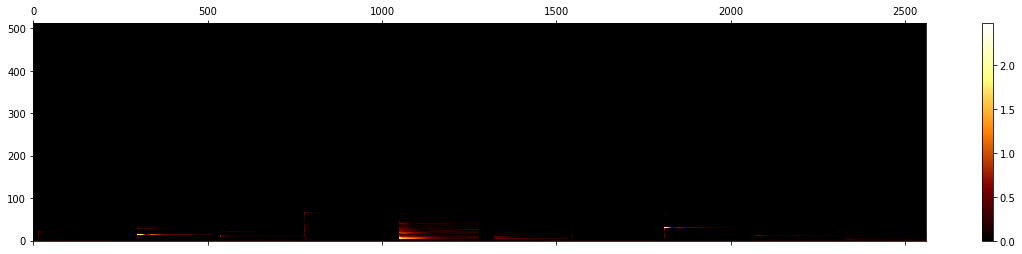

In [6]:
# plot the original
x_test = np.reshape(x_test,newshape=(10,512,256))
orig = np.zeros((512,0))
for n in range (len(x_test)):
    orig = np.concatenate((orig,x_test[n]),axis=1)
    
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(orig, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

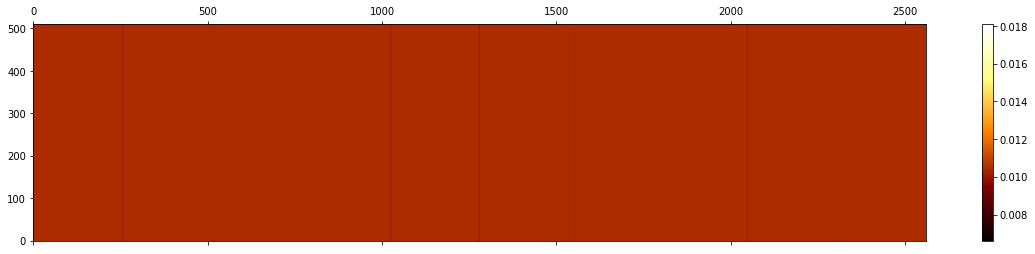

In [7]:
# plot the reconstruction
rec = np.zeros((512,0))
for n in range (len(y_test)):
    rec = np.concatenate((rec,y_test[n]),axis=1)
    
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(rec, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

In [ ]:
# (transformation only)
# plot the original target
target = np.zeros((512,0))
for n in range (len(clarinet_validation_set)):
    target = np.concatenate((target,clarinet_validation_set[n]),axis=1)
    
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(target, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

#### Reconstruction using sinusoids

In [ ]:
# get the reconstruction from a test sinusoid

x_test = np.reshape(x_test,newshape=(512,1760))
print('Decoded image after reshaping:',x_test.shape)

# display original
fig = plt.figure(figsize=[12, 4])
librosa.display.specshow(x_test*norm, sr=44100, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# display reconstruction
fig = plt.figure(figsize=[12, 4])
librosa.display.specshow(y_test*norm, sr=44100, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.tight_layout()
plt.show()

### *If testing with audio files*

In [ ]:
from sklearn import preprocessing

# general parameters
INPUT_FILE = 'samples/Jarrett_Vienna_cut.wav'           # input file for feature evaluation
FFT_SIZE = 1024                                         # size of FFT
HOP_SIZE = 512                                          # hop size (overlap)
DURATION = 30                                           # segment duration (sec)
SR = 44100

y,sr = librosa.core.load(path=INPUT_FILE,duration=DURATION,sr=None)

[mag, phase] = compute_spectra(
            x=y,
            fft_size=FFT_SIZE,
            hop_size=HOP_SIZE,
        )

print(mag.shape)
# reshape in minibatch for structure input
mag = np.reshape(a=scaled_mag,newshape=[12,512,88])


# reshaping
x_test = np.reshape(mag,newshape=(10, 512, 88, 1))
print('Test spectogram of shape', x_test.shape)

In [ ]:
# plot the log spectrogram
scaled_mag = np.reshape(a=scaled_mag, newshape=[512,880]) 
orig = np.reshape(a=mag, newshape=[512,880]) 

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(orig, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

## FILTER VISUALISATION
*(still work in progress)*

In [ ]:
# get the symbolic outputs of each layer given its name
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
# visualise the dictionary
layer_dict

In [ ]:
from keras import backend as K

layer_name = 'leaky_re_lu_1'
filter_index = 0  # there are 256 filters in the first activation layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

In [ ]:
# compute the gradient of the test spectrogram wrt this loss
grads = K.gradients(loss, x_test)

## RECONSTRUCTION
*from a spectrogram using Griffin-Lim algorithm for phase reconstruction*

In [ ]:
# compute the log magnitude of the power spectra via STFT
x, sr = librosa.load(INPUT_FILE, duration=DURATION, sr=SR)
D = librosa.stft(x,n_fft=FFT_SIZE) # D is a complex matrix with the magnitude and phase of the fourier transform
S = np.log1p(np.abs(D)) # Take the magnitude with abs (call it Z) and return log(1 + Z) as the spectrogram

In [ ]:
# plot the log spectrogram
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(S, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

### Phase estimation with autoencoder result

In [ ]:
# estimate the phase information using the Griffin-Lim algorithm
# original spectra
orig = orig[:512,:orig.shape[1]]
# repeat the last frequency bin
orig = np.concatenate((orig,orig[511:,:orig.shape[1]]))

# Algorithm
D = np.expm1(orig) # go back to linear magnitude
p = (2*np.pi) * np.random.random_sample(D.shape) # start with a random estimate
p -= np.pi
for i in range(100): # Do 100 iterations
    Q = D * np.exp(1j*p) # Estimate the full STFT using the magnitude and the phase estimate
    y = librosa.istft(Q) # invert the STFT
    p = np.angle(librosa.stft(y,n_fft=1024)) # Improve the phase estimate using the new signal

In [ ]:
IPython.display.Audio(data=y,rate=44100)

In [8]:
# estimate the phase information using the Griffin-Lim algorithm
# reconstructed spectra

# match STFT size
rec = rec[:512,:rec.shape[1]]
rec = np.concatenate((rec,rec[511:,:rec.shape[1]]))

# Algorithm
D = np.expm1(rec)
p = (2*np.pi) * np.random.random_sample(D.shape) # Start with a random estimate
p -= np.pi
for i in range(100): # Do 10 iterations
    Q = D * np.exp(1j*p) # Estimate the full STFT using the magnitude and the phase estimate
    y = librosa.istft(Q) + 1e-6 # invert the STFT
    p = np.angle(librosa.stft(y,n_fft=1024)) # Improve the phase estimate using the new signal

In [ ]:
IPython.display.Audio(data=y,rate=44100)

In [ ]:
# estimate the phase information using the Griffin-Lim algorithm
# target spectra

# match STFT size
target = target[:512,:rec.shape[1]]
target = np.concatenate((target,target[511:,:rec.shape[1]]))

# Algorithm
D = np.expm1(target)
p = (2*np.pi) * np.random.random_sample(D.shape) # Start with a random estimate
p -= np.pi
for i in range(100): # Do 10 iterations
    Q = D * np.exp(1j*p) # Estimate the full STFT using the magnitude and the phase estimate
    y = librosa.istft(Q) + 1e-6 # invert the STFT
    p = np.angle(librosa.stft(y,n_fft=1024)) # Improve the phase estimate using the new signal

In [ ]:
IPython.display.Audio(data=y,rate=44100)

### Original phase with autoencoder result

In [ ]:
# original spectra
x_phase = np.reshape(a=x_phase,newshape=[513,256*7])

# using original phase information
D = np.expm1(orig)
S = D * np.exp(1j*x_phase) # Estimate the full STFT using the magnitude and the original phase
y = librosa.istft(S)

In [ ]:
IPython.display.Audio(data=y,rate=44100)

In [ ]:
# reconstructed spectra
y_phase = np.reshape(a=y_phase,newshape=[513,256*7])

# using original phase information
D = np.expm1(rec)
S = D * np.exp(1j*y_phase) # Estimate the full STFT using the magnitude and the original phase
y = librosa.istft(S)

In [ ]:
IPython.display.Audio(data=y,rate=44100)

In [ ]:
# target spectra
y_phase = np.reshape(a=y_phase,newshape=[513,256*7])

# using original phase information
D = np.expm1(target)
S = D * np.exp(1j*y_phase) # Estimate the full STFT using the magnitude and the original phase
y = librosa.istft(S)

In [ ]:
IPython.display.Audio(data=y,rate=44100)

In [ ]:
from keras import layers